# Assigment 2b Part 1

In [ ]:
#Mount from drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Import necessary modules
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
import csv
import re
import pylab
import time

# Q1

In [ ]:
#Constants
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 256]
FILTER_SHAPE2 = [20, 1]
FILTER_SHAPE3 = [20, 20]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
one_hot_size = 256
no_epochs = 250
lr = 0.01

seed = 10
tf.random.set_seed(seed)

In [ ]:
# Read data with [character]
def vocabulary(strings):
    chars = sorted(list(set(list(''.join(strings)))))
    char_to_ix = { ch:i for i,ch in enumerate(chars) }
    vocab_size = len(chars)
    return vocab_size, char_to_ix

In [ ]:
def preprocess(strings, char_to_ix, MAX_LENGTH):
    data_chars = [list(d.lower()) for _, d in enumerate(strings)]
    for i, d in enumerate(data_chars):
        if len(d)>MAX_LENGTH:
            d = d[:MAX_LENGTH]
        elif len(d) < MAX_LENGTH:
            d += [' '] * (MAX_LENGTH - len(d))
            
    data_ids = np.zeros([len(data_chars), MAX_LENGTH], dtype=np.int64)
    for i in range(len(data_chars)):
        for j in range(MAX_LENGTH):
            data_ids[i, j] = char_to_ix[data_chars[i][j]]
    return np.array(data_ids)

In [ ]:
def read_data_chars():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./drive/My Drive/CZ4042/Assignment 2/train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./drive/My Drive/CZ4042/Assignment 2/test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))


    vocab_size, char_to_ix = vocabulary(x_train+x_test)
    x_train = preprocess(x_train, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, char_to_ix, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    return x_train, y_train, x_test, y_test


In [ ]:
x_train, y_train, x_test, y_test = read_data_chars()
# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
# Build model
tf.keras.backend.set_floatx('float32')

In [ ]:
class CharCNN(Model):
    def __init__(self, vocab_size=256, add_dropout=False):
        super(CharCNN, self).__init__()
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        # Weight variables and RNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = tf.one_hot(x, one_hot_size)
        x = x[..., tf.newaxis] 
        x = self.conv1(x)
        x = self.pool1(x)
        if self.add_dropout:
          x = tf.nn.dropout(x, drop_rate)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flatten(x)
        if self.add_dropout:
          x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
model = CharCNN(256)

In [ ]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [ ]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Training function
def train_step(model, x, label, drop_rate):
    with tf.GradientTape() as tape:
        out = model(x, drop_rate)
        loss = loss_object(label, out)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    train_loss(loss)
    train_accuracy(labels, out)

In [ ]:
# Testing function
def test_step(model, x, label, drop_rate=0):
    out = model(x,drop_rate)
    t_loss = loss_object(label, out)
    test_loss(t_loss)
    test_accuracy(label, out)

In [ ]:
#Results Array
test_acc_char_cnn = []
train_loss_char_cnn = []

#Start program time
start_time = time.time()

#Loop for each epoch
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model, images, labels, drop_rate=0)

    #Save Results
    test_acc_char_cnn.append(test_accuracy.result())
    train_loss_char_cnn.append(train_loss.result())
  
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

#Store program execution time
time_charCNN = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charCNN))

Epoch 1, Loss: 2.701719045639038, Accuracy: 0.08428571373224258, Test Loss: 2.6951868534088135, Test Accuracy: 0.1014285683631897
Epoch 2, Loss: 2.6916980743408203, Accuracy: 0.09892857074737549, Test Loss: 2.6871163845062256, Test Accuracy: 0.11142857372760773
Epoch 3, Loss: 2.6834115982055664, Accuracy: 0.12428571283817291, Test Loss: 2.6798226833343506, Test Accuracy: 0.12285714596509933
Epoch 4, Loss: 2.6754963397979736, Accuracy: 0.14249999821186066, Test Loss: 2.672753095626831, Test Accuracy: 0.1485714316368103
Epoch 5, Loss: 2.667858123779297, Accuracy: 0.15464285016059875, Test Loss: 2.665666341781616, Test Accuracy: 0.16285714507102966
Epoch 6, Loss: 2.6598730087280273, Accuracy: 0.16625000536441803, Test Loss: 2.658374547958374, Test Accuracy: 0.16571427881717682
Epoch 7, Loss: 2.651761054992676, Accuracy: 0.17446428537368774, Test Loss: 2.6507086753845215, Test Accuracy: 0.16857142746448517
Epoch 8, Loss: 2.643279552459717, Accuracy: 0.17624999582767487, Test Loss: 2.642877

In [ ]:
#Execution time
print(str(time_charCNN/60)[0:3]+" mins")

128 mins


No handles with labels found to put in legend.


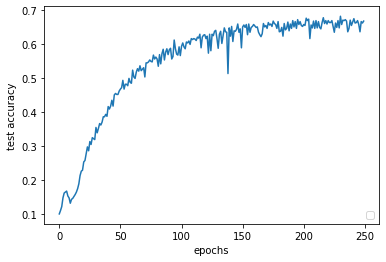

In [ ]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_char_cnn)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

No handles with labels found to put in legend.


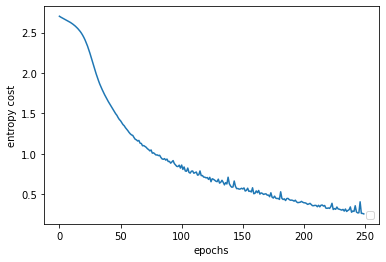

In [ ]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_char_cnn)
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# Q2

In [ ]:
class WordCNN(Model):
    def __init__(self, vocab_size=256, add_dropout = False):
        super(WordCNN, self).__init__()
        self.vocab_size = vocab_size
        self.add_dropout = add_dropout
        # Weight variables and RNN cell
        self.conv1 = layers.Conv2D(N_FILTERS, FILTER_SHAPE3, padding='VALID', activation='relu', use_bias=True)
        self.pool1 = layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
        self.conv2 = layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
        self.flatten = layers.Flatten()
        self.embedding = layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)

        self.dense = layers.Dense(MAX_LABEL, activation='softmax')

    def call(self, x, drop_rate=0.5):
        # forward
        x = self.embedding(x)
        x = tf.reshape(x, [-1, MAX_DOCUMENT_LENGTH, EMBEDDING_SIZE, 1])
        x = self.conv1(x)
        x = self.pool1(x)
        if self.add_dropout:
          x = tf.nn.dropout(x, drop_rate)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flatten(x)
        if self.add_dropout:
          x = tf.nn.dropout(x, drop_rate)
        logits = self.dense(x)
        return logits

In [ ]:
#Set Model for Word CNN
model2 = WordCNN(100)

# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
#Result Array
test_acc_word = []
train_losses_word = []

#Start program time
start_time = time.time()

for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model2, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model2, images, labels, drop_rate=0)

    #Save Results
    test_acc_word.append(test_accuracy.result())
    train_losses_word.append(train_loss.result())
  
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

#Store program execution time
time_wordCNN = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordCNN))

Epoch 1, Loss: 2.7060461044311523, Accuracy: 0.07124999910593033, Test Loss: 2.703861951828003, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.702130079269409, Accuracy: 0.0714285746216774, Test Loss: 2.700693130493164, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.699244976043701, Accuracy: 0.0714285746216774, Test Loss: 2.697859525680542, Test Accuracy: 0.0714285746216774
Epoch 4, Loss: 2.6964855194091797, Accuracy: 0.0714285746216774, Test Loss: 2.695158004760742, Test Accuracy: 0.0714285746216774
Epoch 5, Loss: 2.69382643699646, Accuracy: 0.0714285746216774, Test Loss: 2.692507028579712, Test Accuracy: 0.0714285746216774
Epoch 6, Loss: 2.6912617683410645, Accuracy: 0.0714285746216774, Test Loss: 2.689913511276245, Test Accuracy: 0.0714285746216774
Epoch 7, Loss: 2.6887378692626953, Accuracy: 0.0714285746216774, Test Loss: 2.687331199645996, Test Accuracy: 0.0714285746216774
Epoch 8, Loss: 2.686248540878296, Accuracy: 0.0714285746216774, Test Loss: 2.6848156452178955, Test 

In [ ]:
#Execution time
print(str(time_wordCNN/60)[0:4]+" mins")

12.6 mins


No handles with labels found to put in legend.


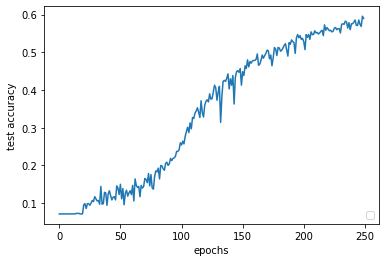

In [ ]:
# Plot test accuracy
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_word)
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

No handles with labels found to put in legend.


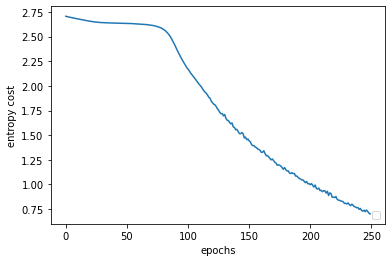

In [ ]:
# Plot train loss
pylab.figure()
pylab.plot(np.arange(no_epochs), train_losses_word)
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')

# Q5

With Dropouts

In [25]:
#Run with dropout for Char CNN
model_char_cnn_d = CharCNN(256, add_dropout = True)
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Results Array
test_acc_char_cnn_dropout = []
train_loss_char_cnn_dropout = []

#Start program time
start_time = time.time()

#Loop for each epoch
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_char_cnn_d, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_char_cnn_d, images, labels, drop_rate=0)

    #Save Results
    test_acc_char_cnn_dropout.append(test_accuracy.result())
    train_loss_char_cnn_dropout.append(train_loss.result())
  
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

#Store program execution time
time_charCNN_dropout = time.time() - start_time
print("--- Took: %s seconds ---" % (time_charCNN_dropout))

Epoch 1, Loss: 2.7046895027160645, Accuracy: 0.07214285433292389, Test Loss: 2.6985905170440674, Test Accuracy: 0.0714285746216774
Epoch 2, Loss: 2.6961095333099365, Accuracy: 0.0714285746216774, Test Loss: 2.6926348209381104, Test Accuracy: 0.0714285746216774
Epoch 3, Loss: 2.68808650970459, Accuracy: 0.07964285463094711, Test Loss: 2.6870410442352295, Test Accuracy: 0.07285714149475098
Epoch 4, Loss: 2.6863250732421875, Accuracy: 0.07767856866121292, Test Loss: 2.6831836700439453, Test Accuracy: 0.10000000149011612
Epoch 5, Loss: 2.6803054809570312, Accuracy: 0.08124999701976776, Test Loss: 2.6770951747894287, Test Accuracy: 0.11714285612106323
Epoch 6, Loss: 2.672039270401001, Accuracy: 0.08839285373687744, Test Loss: 2.671111822128296, Test Accuracy: 0.10571428388357162
Epoch 7, Loss: 2.6691105365753174, Accuracy: 0.09428571164608002, Test Loss: 2.665959119796753, Test Accuracy: 0.14142857491970062
Epoch 8, Loss: 2.6619856357574463, Accuracy: 0.09375, Test Loss: 2.6591856479644775,

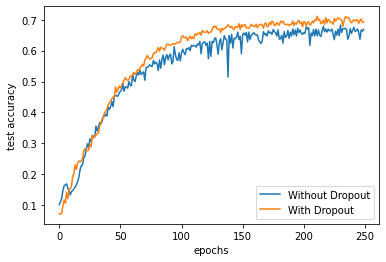

In [26]:
# Plot test accuracy w and w/o dropout for char CNN
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_char_cnn, label='Without Dropout')
pylab.plot(np.arange(no_epochs), test_acc_char_cnn_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

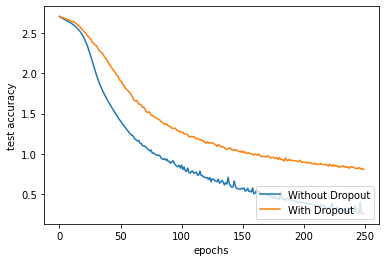

In [27]:
# Plot train loss w and w/o dropout for char CNN
pylab.figure()
pylab.plot(np.arange(no_epochs), train_loss_char_cnn, label='Without Dropout')
pylab.plot(np.arange(no_epochs), train_loss_char_cnn_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

In [28]:
#Run with dropout for Char CNN
model_word_cnn_d = WordCNN(256, add_dropout = True)
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

#Results Array
test_acc_word_cnn_dropout = []
train_loss_word_cnn_dropout = []

#Start program time
start_time = time.time()

#Loop for each epoch
for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(model_word_cnn_d, images, labels, drop_rate=0.5)

    for images, labels in test_ds:
        test_step(model_word_cnn_d, images, labels, drop_rate=0)

    #Save Results
    test_acc_word_cnn_dropout.append(test_accuracy.result())
    train_loss_word_cnn_dropout.append(train_loss.result())
  
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          test_loss.result(),
                          test_accuracy.result()))

#Store program execution time
time_wordCNN_dropout = time.time() - start_time
print("--- Took: %s seconds ---" % (time_wordCNN_dropout))

Epoch 1, Loss: 2.7050161361694336, Accuracy: 0.07089285552501678, Test Loss: 2.7035939693450928, Test Accuracy: 0.07428571581840515
Epoch 2, Loss: 2.7016360759735107, Accuracy: 0.07517857104539871, Test Loss: 2.7003211975097656, Test Accuracy: 0.06714285910129547
Epoch 3, Loss: 2.6982827186584473, Accuracy: 0.07678571343421936, Test Loss: 2.6970300674438477, Test Accuracy: 0.08857142925262451
Epoch 4, Loss: 2.6957101821899414, Accuracy: 0.07214285433292389, Test Loss: 2.6942074298858643, Test Accuracy: 0.08285713940858841
Epoch 5, Loss: 2.694565534591675, Accuracy: 0.06767857074737549, Test Loss: 2.6919753551483154, Test Accuracy: 0.07999999821186066
Epoch 6, Loss: 2.691720962524414, Accuracy: 0.07035714387893677, Test Loss: 2.689857244491577, Test Accuracy: 0.0771428570151329
Epoch 7, Loss: 2.6921803951263428, Accuracy: 0.06232142820954323, Test Loss: 2.6882035732269287, Test Accuracy: 0.07000000029802322
Epoch 8, Loss: 2.68668270111084, Accuracy: 0.07071428745985031, Test Loss: 2.685

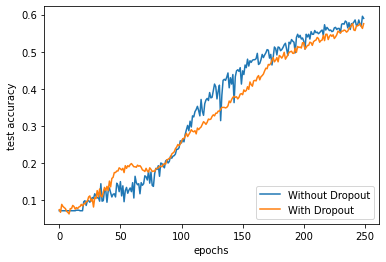

In [31]:
# Plot test accuracy w and w/o dropout for word CNN
pylab.figure()
pylab.plot(np.arange(no_epochs), test_acc_word, label='Without Dropout')
pylab.plot(np.arange(no_epochs), test_acc_word_cnn_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('test accuracy')
pylab.legend(loc='lower right')

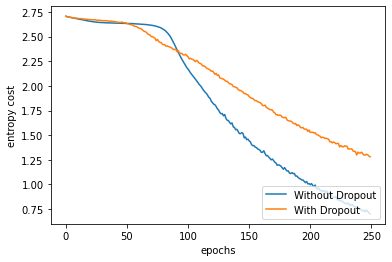

In [33]:
# Plot entropy cost w and w/o dropout for word CNN
pylab.figure()
pylab.plot(np.arange(no_epochs), train_losses_word, label='Without Dropout')
pylab.plot(np.arange(no_epochs), train_loss_word_cnn_dropout, label='With Dropout')
pylab.xlabel('epochs')
pylab.ylabel('entropy cost')
pylab.legend(loc='lower right')